# Model building

In [23]:
# Import necessary libraries for file handling, data manipulation, and visualization
from pathlib import Path
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import uniform, randint

# Enable experimental features in scikit-learn
from sklearn.experimental import enable_halving_search_cv

# Import machine learning utilities for model selection and evaluation
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV, train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, roc_auc_score
)
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

# Change the working directory to the parent directory
%cd ..

# Import custom configuration settings
import src.configuration as config

/


## 1. Load data

In [2]:
# Import necessary library for data manipulation
import pandas as pd

# Load the training dataset from the specified CSV file
train_df = pd.read_csv(config.TRAINING_DATAFILE)

# Load the testing dataset from the specified CSV file
test_df = pd.read_csv(config.TESTING_DATAFILE)
# verify the shape of the datasets
print(f"Training dataset shape: {train_df.shape}")
print(f"Testing dataset shape: {test_df.shape}")


Training dataset shape: (457181, 4)
Testing dataset shape: (152394, 4)


In [3]:
# Display the first 5 rows of the training dataset in transposed format 
# for better readability of column values
train_df.head(5).T

,0,1,2,3,4
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,0.963630,-0.969231,0.771625,0.819152,-0.930418
time_cos,-0.267238,-0.246153,-0.636078,-0.573576,0.366501
route_encoded,385.000000,709.000000,31.000000,381.000000,10.000000


In [4]:
# Display the first 5 rows of the testing dataset in transposed format 
# for better readability of column values
test_df.head(5).T

,0,1,2,3,4
incident,0.0,0.000000,0.000000,0.000000,0.000000
time_sin,0.0,-0.406737,-0.801254,-0.998392,-0.622515
time_cos,1.0,0.913545,0.598325,-0.056693,-0.782608
route_encoded,85.0,32.000000,421.000000,30.000000,553.000000


## 2. Cross-validation: model

In [5]:
# Import necessary libraries for cross-validation and model training
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Define a function to perform cross-validation on a boosting model
def cross_val_boosting_model(
    training_data: pd.DataFrame, 
    testing_data: pd.DataFrame, 
    target_variable: str, 
    model
):
    """
    Perform cross-validation on a boosting model and return training/testing data splits.

    Parameters:
    - training_data (pd.DataFrame): The training dataset.
    - testing_data (pd.DataFrame): The testing dataset.
    - target_variable (str): The name of the target column.
    - model: The machine learning model to be trained.

    Returns:
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training labels.
    - y_test (pd.Series): Testing labels.
    - y_pred (np.ndarray): Model predictions on the test set.
    """
    
    # Split features and target variable for training and testing sets
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Perform 5-fold cross-validation and print scores
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Cross-validation scores:", scores)
    print(f"Mean CV Score: {scores.mean():.4f}")

    return X_train, y_train, y_test, y_pred

# Initialize the HistGradientBoostingClassifier with a fixed random state for reproducibility
hist_boost_model = HistGradientBoostingClassifier(random_state=42)

# Perform cross-validation and retrieve training/testing splits
X_train, y_train, y_test, y_pred = cross_val_boosting_model(train_df, test_df, 'incident', hist_boost_model)

Cross-validation scores: [0.99656594 0.99601907 0.99612844 0.99593158 0.99592064]
Mean CV Score: 0.9961


## 3. Test-set performance: confusion matrix

Saving plot to: ./src/static/8_confusion_matrix.png


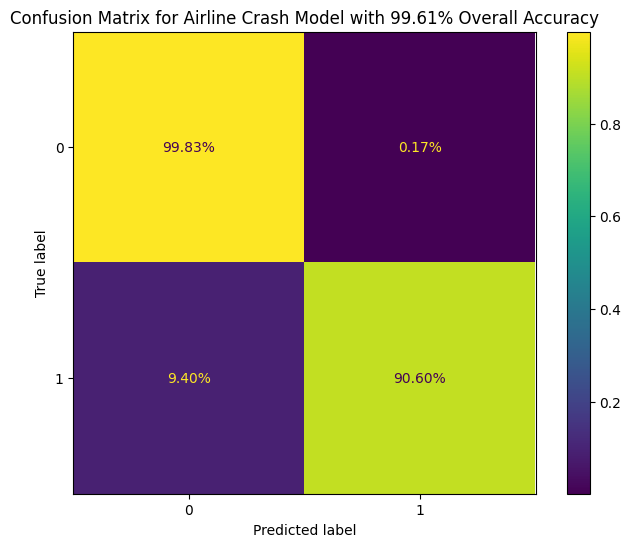

In [6]:
# Import necessary libraries for evaluation and visualization
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define a function to plot a confusion matrix for model evaluation
def confusion_plot(y_test, y_pred, model):
    """
    Generate and save a confusion matrix plot to evaluate the model's performance.

    Parameters:
    - y_test (pd.Series or np.ndarray): True labels from the test dataset.
    - y_pred (np.ndarray): Predicted labels from the model.
    - model: The trained machine learning model.

    Saves:
    - A confusion matrix plot as a PNG file.
    """
    
    # Calculate overall accuracy percentage
    acc = accuracy_score(y_test, y_pred) * 100

    # Compute the normalized confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

    # Create a figure for the confusion matrix plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    # Display the confusion matrix with class labels
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    ax.set(title=f'Confusion Matrix for Airline Crash Model with {acc:.2f}% Overall Accuracy')
    display.plot(ax=ax, values_format='.2%')

    # Ensure the output directory exists
    output_dir = config.STATIC_APP_ASSETS
    os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

    # Construct the full file path for saving the plot
    file_path = os.path.join(output_dir, "8_confusion_matrix.png")

    # Save the figure as a PNG file with tight bounding box
    plt.savefig(file_path, format="png", bbox_inches="tight")

    # Print confirmation message
    print(f"Saving plot to: {file_path}")

    # Display the plot
    plt.show()

# Generate the confusion matrix plot for the trained model
confusion_plot(y_test, y_pred, hist_boost_model)

## 4. Model optimization

### Probability Calibration

Saving plot to: ./src/static/9_calibration_plot.png


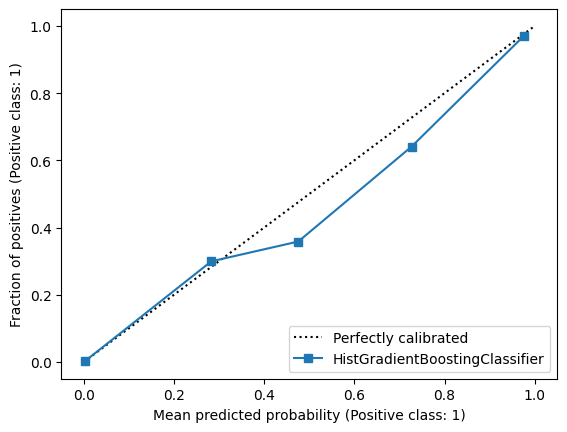

In [8]:
# Import necessary libraries for model calibration and visualization
import os
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

# Define a function to check the calibration of the model's probability predictions
def calibration_plot(model, testing_data: pd.DataFrame, target_variable: str):
    """
    Generate and save a calibration plot to evaluate the model's probability calibration.

    Parameters:
    - model: The trained machine learning model.
    - testing_data (pd.DataFrame): The test dataset containing features and target variable.
    - target_variable (str): The name of the target column.

    Saves:
    - A calibration plot as a PNG file.
    """
    
    # Extract features and target variable from the test dataset
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]

    # Generate the calibration plot
    disp = CalibrationDisplay.from_estimator(model, X_test, y_test)

    # Ensure the output directory exists
    output_dir = config.STATIC_APP_ASSETS
    os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

    # Construct the full file path for saving the plot
    file_path = os.path.join(output_dir, "9_calibration_plot.png")

    # Save the figure as a PNG file with tight bounding box
    plt.savefig(file_path, format="png", bbox_inches="tight")

    # Print confirmation message
    print(f"Saving plot to: {file_path}")

    # Display the plot
    plt.show()

# Generate the calibration plot for the trained model
calibration_plot(hist_boost_model, test_df, 'incident')

In [9]:
# Define a function to calibrate the probabilities of a given model
def calibrate_probability(model, training_data: pd.DataFrame, target_variable: str):
    """
    Calibrate the probabilities of a given model using cross-validation.

    Parameters:
    - model: The trained machine learning model to be calibrated.
    - training_data (pd.DataFrame): The dataset used for training.
    - target_variable (str): The name of the target column.

    Returns:
    - calibrated_hist_boost_model: The calibrated model with probability estimates.
    """
    
    # Extract features and target variable from the training dataset
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]

    # Initialize the calibrated classifier with 5-fold cross-validation
    calibrated_hist_boost_model = CalibratedClassifierCV(model, cv=5)

    # Fit the calibrated model on the training data
    calibrated_hist_boost_model.fit(X_train, y_train)

    return calibrated_hist_boost_model

# Perform probability calibration on the trained model
calibrated_hist_boost_model = calibrate_probability(hist_boost_model, train_df, 'incident')

In [10]:
# Define a function to obtain probability predictions from the calibrated model
def predict_calibrated_probabilities(testing_data: pd.DataFrame, target_variable: str):
    """
    Generate probability predictions using the calibrated model.

    Parameters:
    - testing_data (pd.DataFrame): The dataset used for testing.
    - target_variable (str): The name of the target column.

    Returns:
    - calibrated_probability (np.ndarray): Predicted probabilities for each class.
    """
    
    # Extract features and target variable from the test dataset
    X_test = testing_data.drop(columns=target_variable)
    y_true = testing_data[target_variable]  # True labels (not used in prediction but useful for evaluation)

    # Obtain probability predictions from the calibrated model
    calibrated_probability = calibrated_hist_boost_model.predict_proba(X_test)

    return calibrated_probability

# Generate probability predictions using the calibrated model
calibrated_probability = predict_calibrated_probabilities(test_df, 'incident')

In [11]:
# Extract the probabilities for the positive class (class index 1)
positive_class_probability = calibrated_probability[:, 1]

# Convert probabilities to percentage format for better readability
positive_class_probability *= 100

# Display the positive class probabilities
positive_class_probability

array([0.0837919 , 0.53658969, 0.04948704, ..., 0.02429957, 0.03658822,
       0.02695698])

In [12]:
# Check the number of unique probability values in the positive class predictions
unique_probabilities_count = np.unique(positive_class_probability).size

# Display the count of unique probabilities
unique_probabilities_count

14273

In [13]:
# visual inspection of unique probabilities
np.unique(positive_class_probability)

array([1.24757122e-02, 1.29806152e-02, 1.31254384e-02, ...,
       9.89713724e+01, 9.89732989e+01, 9.90038075e+01])

Saving plot to: ./src/static/10_calibration_plot.png


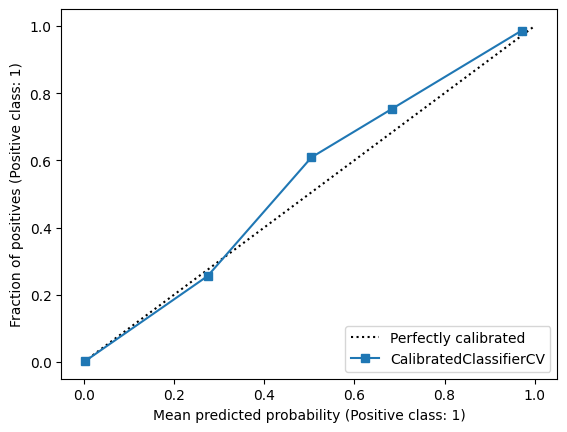

In [15]:
# Import necessary libraries for model calibration and visualization
import os
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

# Define a function to check the calibration of the model's probability predictions
def calibration_plot(model, testing_data: pd.DataFrame, target_variable: str):
    """
    Generate and save a calibration plot to evaluate the model's probability calibration.

    Parameters:
    - model: The trained machine learning model.
    - testing_data (pd.DataFrame): The test dataset containing features and target variable.
    - target_variable (str): The name of the target column.

    Saves:
    - A calibration plot as a PNG file.
    """
    
    # Extract features and target variable from the test dataset
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]

    # Generate the calibration plot
    disp = CalibrationDisplay.from_estimator(model, X_test, y_test)

    # Ensure the output directory exists
    output_dir = config.STATIC_APP_ASSETS
    os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

    # Construct the full file path for saving the plot
    file_path = os.path.join(output_dir, "10_calibration_plot.png")

    # Save the figure as a PNG file with tight bounding box
    plt.savefig(file_path, format="png", bbox_inches="tight")

    # Print confirmation message
    print(f"Saving plot to: {file_path}")

    # Display the plot
    plt.show()

# Plot the calibration curve for the calibrated model
calibration_plot(calibrated_hist_boost_model, test_df, 'incident')

In [16]:
# Define a function to obtain predictions from the calibrated model
def get_predictions(training_data: pd.DataFrame, testing_data: pd.DataFrame, target_variable: str, model):
    """
    Train the model and obtain predictions on the test dataset.

    Parameters:
    - training_data (pd.DataFrame): The dataset used for training.
    - testing_data (pd.DataFrame): The dataset used for testing.
    - target_variable (str): The name of the target column.
    - model: The machine learning model to be trained and used for predictions.

    Returns:
    - y_pred (np.ndarray): Predicted labels for the test dataset.
    - y_test (pd.Series): Actual labels from the test dataset.
    """
    
    # Extract features and target variable from the training dataset
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]

    # Extract features and target variable from the test dataset
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate model accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100

    # Print the predicted labels and accuracy score
    print("Predicted labels:", y_pred)
    print(f"Model Accuracy: {accuracy:.2f}%")


    return y_pred, y_test

# Obtain predictions using the calibrated model
y_pred, y_test = get_predictions(train_df, test_df, 'incident', calibrated_hist_boost_model)

Predicted labels: [0 0 0 ... 0 0 0]
Model Accuracy: 99.67%


Saving plot to: ./src/static/11_confusion_matrix.png


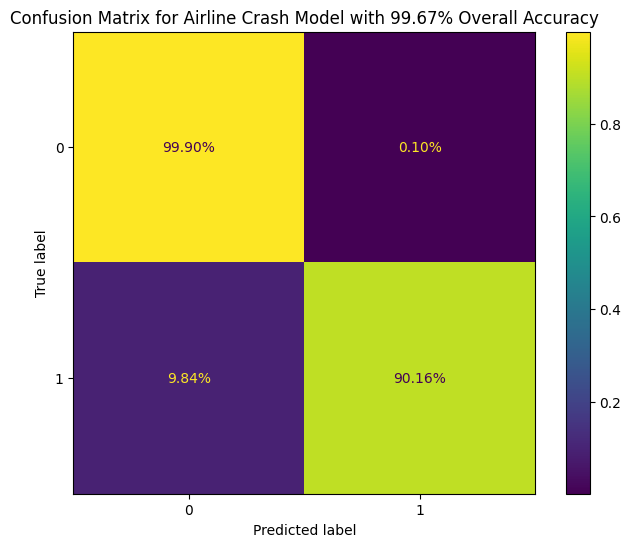

In [17]:
# Import necessary libraries for evaluation and visualization
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define a function to plot a confusion matrix for model evaluation
def confusion_plot(y_test, y_pred, model):
    """
    Generate and save a confusion matrix plot to evaluate the model's performance.

    Parameters:
    - y_test (pd.Series or np.ndarray): True labels from the test dataset.
    - y_pred (np.ndarray): Predicted labels from the model.
    - model: The trained machine learning model.

    Saves:
    - A confusion matrix plot as a PNG file.
    """
    
    # Calculate overall accuracy percentage
    acc = accuracy_score(y_test, y_pred) * 100

    # Compute the normalized confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

    # Create a figure for the confusion matrix plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    # Display the confusion matrix with class labels
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    ax.set(title=f'Confusion Matrix for Airline Crash Model with {acc:.2f}% Overall Accuracy')
    display.plot(ax=ax, values_format='.2%')

    # Ensure the output directory exists
    output_dir = config.STATIC_APP_ASSETS
    os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

    # Construct the full file path for saving the plot
    file_path = os.path.join(output_dir, "11_confusion_matrix.png")

    # Save the figure as a PNG file with tight bounding box
    plt.savefig(file_path, format="png", bbox_inches="tight")

    # Print confirmation message
    print(f"Saving plot to: {file_path}")

    # Display the plot
    plt.show()

# Plot the confusion matrix for the calibrated model
confusion_plot(y_test, y_pred, calibrated_hist_boost_model)

Saving plot to: ./src/static/12_prob_plot.png


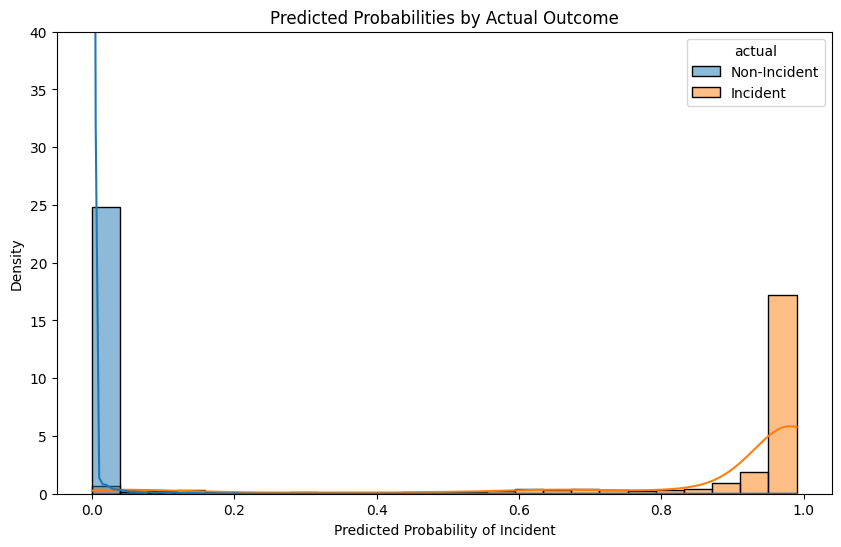

In [19]:
# Define a function to plot the predicted probabilities of the calibrated model
def probabilities_plot(model, testing_data: pd.DataFrame):
    """
    Generate a histogram plot of predicted probabilities for incidents.

    Parameters:
    - model: The trained machine learning model.
    - testing_data (pd.DataFrame): The test dataset containing features and target variable.

    Displays:
    - A histogram showing the distribution of predicted probabilities for incidents.
    """
    
    # Extract actual labels and features from the test dataset
    y_true = testing_data['incident']
    X_test = testing_data.drop(columns=['incident'])

    # Obtain predicted probabilities for the positive class (incident)
    prob_incident = model.predict_proba(X_test)[:, 1]

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'probability': prob_incident,
        'actual': y_true.map({0: 'Non-Incident', 1: 'Incident'})  # Map labels for better readability
    })

    # Create the histogram plot
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=plot_df, x='probability', hue='actual', bins=25, kde=True, 
        stat='density', common_norm=False
    )

    # Set plot title and labels
    plt.title('Predicted Probabilities by Actual Outcome')
    plt.xlabel('Predicted Probability of Incident')
    plt.ylabel('Density')

    # Set y-axis limit for better visualization
    plt.ylim(top=40)
    # Ensure the directory exists
    output_dir = config.STATIC_APP_ASSETS
    # Join the filename to the directory path
    file_path = os.path.join(output_dir, "12_prob_plot.png")
    # Save the figure
    plt.savefig(file_path, format="png", bbox_inches="tight")
    print(f"Saving plot to: {file_path}")
    # Display the plot
    plt.show()

# Generate the probability distribution plot for the calibrated model
probabilities_plot(calibrated_hist_boost_model, test_df)

### Hyperparameter Tuning

In [20]:
# Import necessary library for hyperparameter tuning
from sklearn.model_selection import HalvingGridSearchCV

# Define a function to optimize the model via hyperparameter tuning
def get_best_params(model, optimizer):
    """
    Perform hyperparameter tuning using the specified optimizer.

    Parameters:
    - model: The machine learning model to be optimized.
    - optimizer: The optimization method (e.g., HalvingGridSearchCV).

    Returns:
    - grid (object): The fitted hyperparameter search object.
    """
    
    # Define the hyperparameter search space
    hyper_params = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Controls step size in gradient boosting
        'max_iter': [100, 200, 500, 1000],  # Number of boosting iterations
        'max_leaf_nodes': [15, 31, 63, 127],  # Maximum number of leaves per tree
        'l2_regularization': [0.0, 0.1, 1.0, 10.0],  # Regularization strength
    }

    # Perform hyperparameter tuning using the specified optimizer
    grid = optimizer(model, hyper_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)

    return grid

# Optimize the HistGradientBoostingClassifier using HalvingGridSearchCV
grid = get_best_params(hist_boost_model, HalvingGridSearchCV)

In [ ]:
# Flag to determine whether to run hyperparameter tuning
run_grid = True

if run_grid:
    # Suppress warnings during grid search
    def warn(*args, **kwargs):
        pass

    warnings.warn = warn

    # Fit the grid search model to find the best hyperparameters
    grid.fit(X_train, y_train)

    # Print the best hyperparameters found
    print(f"Best hyperparameters: {grid.best_params_}")
    

Best hyperparameters: {'l2_regularization': 10.0, 'learning_rate': 0.1, 'max_iter': 500, 'max_leaf_nodes': 63}


In [ ]:
# create an optimized model based on the best hyperparameters
optimized_hist_boost_model = HistGradientBoostingClassifier(l2_regularization= 10.0, learning_rate= 0.01, max_iter= 1000, max_leaf_nodes= 31, 
                                                            random_state=42)

X_train, y_train, y_test, y_pred = cross_val_boosting_model(train_df, test_df, 'incident', optimized_hist_boost_model)

[0.99692263 0.99691231 0.99645789 0.99658181 0.99663345]


In [7]:
# obtain the predictions from the optimized model
y_pred, y_test = get_predictions(train_df, test_df, 'incident', optimized_hist_boost_model)

[1 0 0 ... 0 0 0]


## 5. Feature Importances

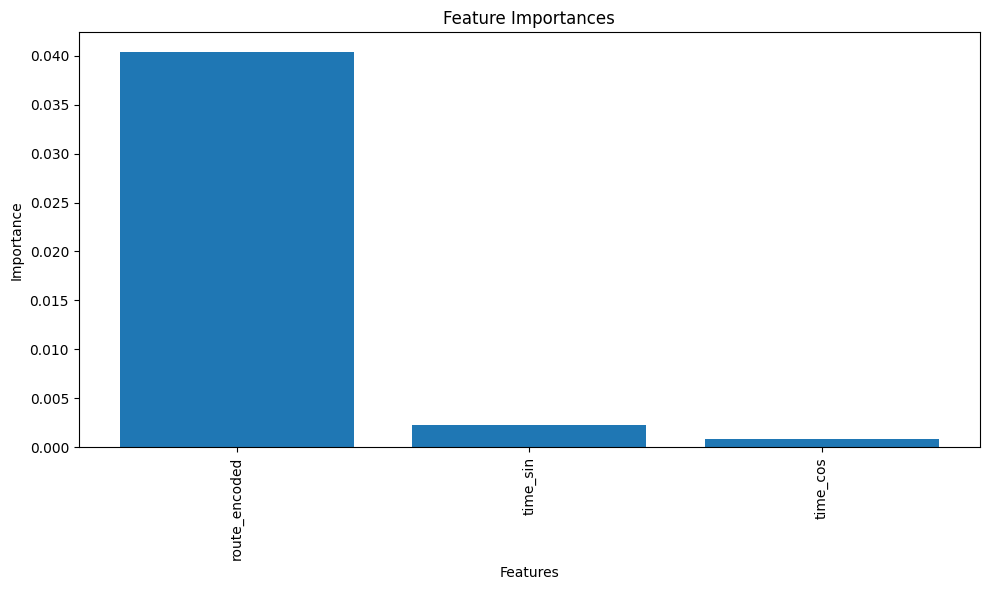

In [ ]:
def feature_importance_plot(model, training_data, sample_size=5000):
    # Compute permutation importances
    X = training_data.drop('incident', axis=1)
    y = training_data['incident']
    X_sample = X.sample(sample_size, random_state=42)
    y_sample = y.loc[X_sample.index]
    result = permutation_importance(model, X_sample, y_sample, n_repeats=5, random_state=42, n_jobs=-1)
    importances = result.importances_mean

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Get feature names from X if it's a DataFrame
    if hasattr(X, "columns"):
        names = [X.columns[i] for i in indices]
    else:
        names = [f"Feature {i}" for i in indices]

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), names, rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()


feature_importance_plot(optimized_hist_boost_model, train_df)

## 6. Test-set performance: confusion matrix

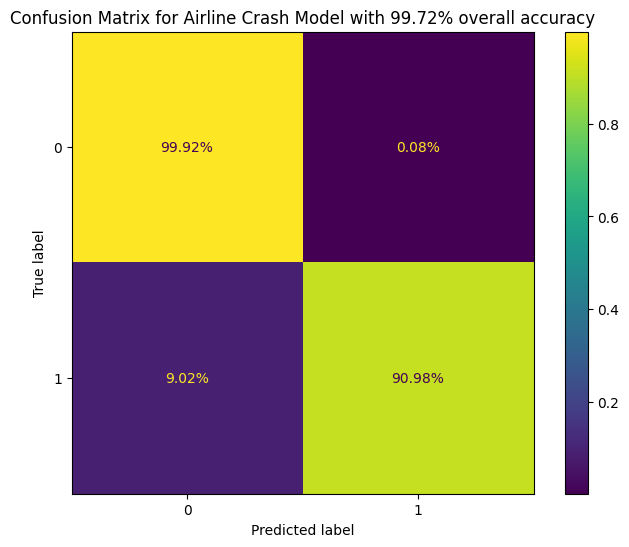

In [ ]:
# plot the optimized model on a confusion matrix
confusion_plot(y_test, y_pred, optimized_hist_boost_model)

## 6. Probability distributions

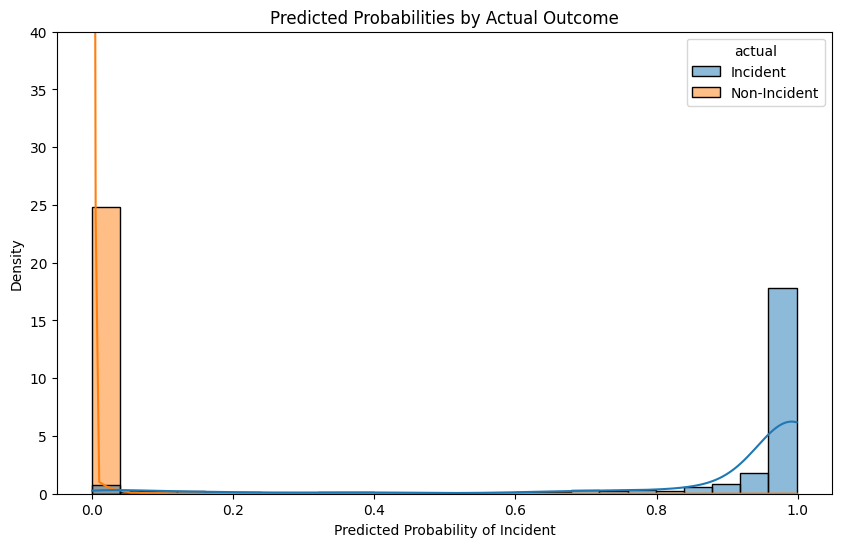

In [ ]:
# plot the distributions of predicted probabilities for 
probabilities_plot(optimized_hist_boost_model, test_df)

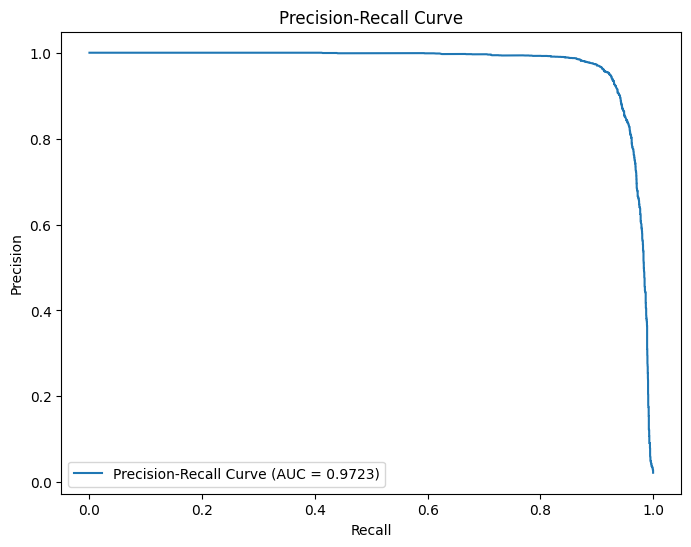

In [6]:
from sklearn.metrics import precision_recall_curve, auc
def precision_recall_plot(model, testing_data):
    y_true = testing_data['incident']
    X_test = testing_data.drop(columns=['incident'])
    prob_incident = model.predict_proba(X_test)[:, 1]
    
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    auc_score = auc(recall, precision)

    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

precision_recall_plot(optimized_hist_boost_model, test_df)

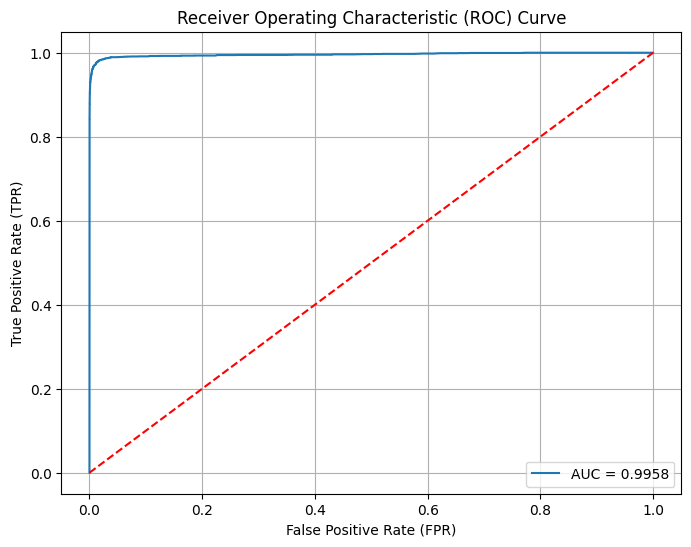

In [6]:
def roc_au_plot(model, testing_data):
    y_true = testing_data['incident']
    X_test = testing_data.drop(columns=['incident'])
    prob_incident = model.predict_proba(X_test)[:, 1]
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, prob_incident)

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, prob_incident)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'r--') # Plot the diagonal line for random guessing
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

roc_au_plot(optimized_hist_boost_model, test_df)

## 7. Save the best model

In [26]:
Path(config.MODEL_DIRECTORY).mkdir(parents=True, exist_ok=True)

with open(config.MODEL, 'wb') as output_file:
    pickle.dump(optimized_hist_boost_model, output_file)
    